In [1]:
pip cache purge


Files removed: 0
Note: you may need to restart the kernel to use updated packages.


Log-likelihood: -10.955678440006915


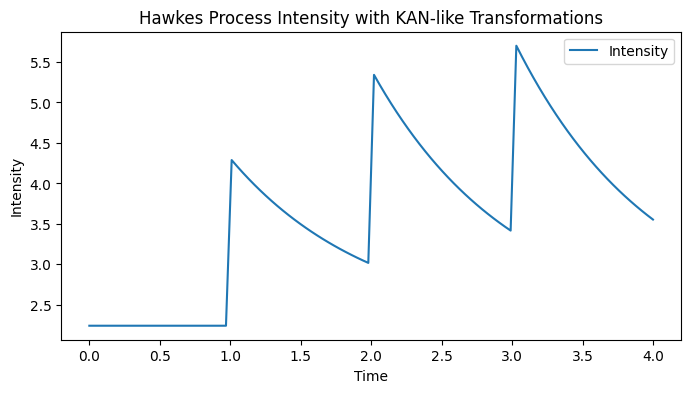

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# --- Define Basic Components ---

#baseline intensity: for demo, a constant value (could be time-varying or spline-based)
def mu(t):
    return 0.5

#exponential kernel function for self-excitation
def gamma_phi(u, phi=1.0):
    return phi * np.exp(-phi * u) if u >= 0 else 0

#dummy univariate transformation functions (as a stand-in for learned splines)
#in practice, these would be spline-based with learnable parameters.
def phi1(x):
    #basic simple linear transformation: a*x + b.
    a, b = 1.0, 0.0
    return a * x + b

def phi2(x):
    a, b = 0.5, 0.1
    return a * x + b

# Kolmogorov–Arnold-like transformations:
# For simplicity, we sum the univariate transformations over the input vector.
def KAN1(x):
    # This could be generalized to: sum_q Φ_q(sum_p φ_{q,p}(x_p))
    return np.sum([phi1(xi) for xi in x])

def KAN2(x):
    return np.sum([phi2(xi) for xi in x])

# --- Define the Hawkes Process Intensity ---

def intensity(t, x_current, past_times, past_xs, alpha=0.8, phi=1.0):
    """
    Compute the Hawkes process intensity at time t.
    
    Parameters:
    - t: current time
    - x_current: covariate vector at time t
    - past_times: list/array of past event times (< t)
    - past_xs: list of covariate vectors corresponding to past events
    - alpha: scaling parameter for the self-exciting term
    - phi: decay parameter for the kernel function
    """
    #baseline intensity modulated by KAN1 transformation
    term1 = mu(t) * np.exp(KAN1(x_current))
    
    #sum contributions from all past events
    term2 = 0.0
    for t_past, x_past in zip(past_times, past_xs):
        if t_past < t:
            term2 += gamma_phi(t - t_past, phi) * np.exp(KAN2(x_past))
    
    return term1 + alpha * term2

# --- Likelihood Computation for a Single Subject ---

def log_likelihood(event_times, covariates, censoring_time=4.0, alpha=0.8, phi=1.0):
    """
    Compute the log-likelihood for a subject with recurrent events.
    
    The likelihood is given by:
        L = (∏_{j} λ(t_j)) * exp(-∫₀^{c} λ(u) du)
    
    Parameters:
    - event_times: array of event times for the subject.
    - covariates: list of covariate vectors at each event time.
    - censoring_time: observation period end time.
    - alpha, phi: parameters for the intensity.
    """
    ll = 0.0
    #sum log intensities at event times
    for j in range(len(event_times)):
        t_j = event_times[j]
        x_tj = covariates[j]
        past_times = event_times[:j]
        past_covs = covariates[:j]
        lam = intensity(t_j, x_tj, past_times, past_covs, alpha, phi)
        ll += np.log(lam)
    
    #subtract the integral of the intensity over [0, censoring_time]
    #for simplicity, we assume the covariates between events are constant and use the first event's covariate.
    def integrand(t):
        #for simplicity, we'll just assume a constant covariate vector (could be interpolated in practice)
        x_t = covariates[0]
        #past events: those that occurred before time t
        past_mask = event_times[event_times < t]
        past_covs = [covariates[i] for i in range(len(event_times)) if event_times[i] < t]
        return intensity(t, x_t, past_mask, past_covs, alpha, phi)
    
    integral, _ = quad(integrand, 0, censoring_time)
    ll -= integral
    return ll

# --- Demo Data and Execution ---

#simulated event times for a subject (in a real application these would be observed data)
event_times = np.array([1.0, 2.0, 3.0])
#example covariates: assume 2-dimensional covariate vectors for each event
covariates = [np.array([0.5, 1.0]), 
              np.array([0.6, 1.2]), 
              np.array([0.7, 1.1])]

#compute the log-likelihood for the subject
ll_value = log_likelihood(event_times, covariates)
print("Log-likelihood:", ll_value)

# --- Plot the Intensity Function ---

#for plotting, we fix a covariate vector (e.g., the one from the first event)
times = np.linspace(0, 4, 100)
#here we use all event times and covariates to compute the self-excitation part
intensities = [intensity(t, covariates[0], event_times, covariates) for t in times]

plt.figure(figsize=(8, 4))
plt.plot(times, intensities, label="Intensity")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.title("Hawkes Process Intensity with KAN-like Transformations")
plt.legend()
plt.show()
